#### Self-organizing LLM wrapper

In [1]:
import torch
from model.model_sorl import SorlModelWrapper
from model.model_sorl import infer_level
from model.model_minimind import MiniMindConfig

full_vocab_list = [11, 50] # Base vocab + abstract vocabs
model = SorlModelWrapper.from_scratch(
    config=MiniMindConfig(vocab_size=sum(full_vocab_list)), # Config needs the total new vocab size
    full_vocab_size_list=full_vocab_list,
    memory_span=5,
    pad_token_id=0
)
# --- Generate text using the custom SORL logic ---

prompt = torch.tensor([[1, 2, 3]])
generated_sequence = model.generate(
    input_ids=prompt,
    max_new_tokens=50,
    temperature=0.0,
    top_k=50,
    force_abstraction_every_n=4  # Example: force an abstraction token every 10 steps
)

print("--- SORL Generation Results ---")
print("Base vocabulary size:", model.vocab_sizes[0].item())
print("Total vocabulary size:", model.model.config.vocab_size)
print("\nGenerated Sequence:", generated_sequence)


result = model.forward(prompt)
print("\n--- Forward propagation (sparse attention) ---")
print("result.logits.shape: ", result.logits.shape)


orig_tokens = torch.tensor([[1,2,3,61,2,4,1,61,3,4,2,61]])

levels = infer_level(orig_tokens, model.vocab_sizes, -1)
denoise_mask = torch.isin(orig_tokens, model.level_mask_tokens[1:])
denoise_levels = levels[denoise_mask]

new_tokens = model.denoise(orig_tokens, denoise_mask, denoise_levels, 0.0)
print("\n--- Denoising ---")
print(f"Generating 2 level-1 tokens in parallel: {orig_tokens[0].tolist()} --> {new_tokens[0].tolist()}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


--- SORL Generation Results ---
Base vocabulary size: 11
Total vocabulary size: 62

Generated Sequence: tensor([[20, 20, 56, 11, 11, 11, 37, 37, 37, 37, 37,  6,  6,  6, 37,  6,  6]])

--- Forward propagation (sparse attention) ---
result.logits.shape:  torch.Size([1, 3, 62])

--- Denoising ---
Generating 2 level-1 tokens in parallel: [1, 2, 3, 61, 2, 4, 1, 61, 3, 4, 2, 61] --> [1, 2, 3, 20, 2, 4, 1, 20, 3, 4, 2, 48]


In [1]:
import torch
from transformers import AutoTokenizer
from dataset.base import MemLoader
from model.model_sorl import SorlModelWrapper
from model.model_minimind import MiniMindConfig
from src.sorl import SORLConfig, sorl_search, compute_per_token_loss, compute_loss

# --- 1. Full Pipeline Initialization ---
print("--- Initializing training components ---")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer to get vocab size and pad token id
tokenizer = AutoTokenizer.from_pretrained('model/')
pad_token_id = tokenizer.pad_token_id

# Initialize the high-performance memory-mapped data loader
dataset = MemLoader('dataset/pretrain_hq.bin', device=device)
print("MemLoader initialized.")

# Initialize the SORL-wrapped model
base_vocab_size = tokenizer.vocab_size
abstract_vocab_sizes = [8]
full_vocab_list = [base_vocab_size] + abstract_vocab_sizes
minimind_config = MiniMindConfig(
    hidden_size=256, num_attention_heads=4, num_hidden_layers=4,
    intermediate_size=512, vocab_size=sum(full_vocab_list)
)
# The .to(device) call will now work correctly
sorl_model = SorlModelWrapper.from_scratch(
    config=minimind_config,
    full_vocab_size_list=full_vocab_list,
    memory_span=1024,
    pad_token_id=0
).to(device)
print("SORL Model initialized.")

--- Initializing training components ---


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


MemLoader initialized.
SORL Model initialized.


In [2]:
# Change can be made on the attention-masking mechanism
# -----------------------------------------------------

# 1. A visualization on where abstraction is added, and what is masked out 
#    I believe when abstraction is added, we only perform a 'distant memory masking'
#    I suspect a meomry distillation based training requires masking out the local chunk where abstraction is present

# .forward method accepts an 'attention_mask' argument

In [3]:
# Configure the SORL search algorithm
sorl_config = SORLConfig(
    n=4, temperature=1.0, K=8, l=1, steps=4, max_t_search=32,
    use_rhythmic_placeholders=True, use_spike_placeholders=False
)

# Set up the optimizer
optimizer = torch.optim.Adam(sorl_model.model.parameters(), lr=1e-4)
print("--- Initialization Complete ---\n")


# --- 2. Perform a Single SORL Training Step ---
print("--- Running one SORL training step ---")
# Get a batch of data instantly
data_batch, _ = dataset.get_batch(batch_size=4)
print(f"Fetched data batch of shape: {data_batch.shape}")

# a) SORL Search Step (run in no_grad context)
with torch.no_grad():
    search_data, switch_ratio = sorl_search(data_batch, sorl_model, sorl_config)
print(f"SORL search complete. New sequence shape: {search_data.shape}")

# b) Forward Pass: Compute per-token loss on the "improved" data
ppt = compute_per_token_loss(sorl_model, search_data)

# c) Compute final SORL loss (combining trajectory and abstraction losses)
ssl_loss, abs_loss = compute_loss(search_data, sorl_model, ppt)
total_loss = ssl_loss + abs_loss
print(f"Computed Loss -> Total: {total_loss.item():.4f} (SSL: {ssl_loss.item():.4f}, Abs: {abs_loss.item():.4f})")

# d) Backward Pass and Optimizer Step
optimizer.zero_grad()
total_loss.backward()
optimizer.step()
print("Optimizer step complete (weights have been updated).")

print("\n--- ✅ Single training step finished! ---")

--- Initialization Complete ---

--- Running one SORL training step ---
Fetched data batch of shape: torch.Size([4, 255])
SORL search complete. New sequence shape: torch.Size([4, 286])
Computed Loss -> Total: 17.7112 (SSL: 8.9598, Abs: 8.7514)
Optimizer step complete (weights have been updated).

--- ✅ Single training step finished! ---


#### Subway

#### Hidden Information compressed into Abstraction

$\textbf{Question 1}$. Do we need the loss mask here? 
- $\textbf{Answer 1}$. Yes, because we want to compare whether abstraction can replace memories, the effect should be on the prediction perplexity only to remove other factors, such as perplexity of provided number etc. 

$\textbf{Question 2}$. When we perform memory degradation, is the the loss of omitted trajectory token prefix still intact? Are we doing un-fair comparison therein?

$\textbf{Issue 1}$. Scheduler is off, when a new abstract token is added, drop ratio is already 1.0 making it impossible for the model to learn via curriculum. 

$\textbf{Question 3}$. How do we reliably justify whether the model has 'learned' to compress the memory into the abstraction?
- $\textbf{Answer 3}$. We've implemented an evaluate function that use un-masked trajectory token perplexity as the reward / score for abstraction. We also compute the advantage of greedy abstraction, as well as the 'best abstraction' within a group of n abstraction sampled at high temperature. 

$\textbf{Idea 1}$. Test on 'information gain' target (proposed in https://github.com/NVlabs/RLP?tab=readme-ov-file#paper). We'd need a EMA reference checkpoint $\pi_{\hat{\theta}}$ and information gain of an abstraction $a \in \mathcal{A}$ is computed by 
$$
r(a) = \pi_{\theta}(x_{i} | x_{<i}, a) - \pi_{\hat{\theta}}(x_{i} | x_{<i})
$$
In RLP, they've found online RL with information gain reward signal suffices to improve model performance by searching for high quality CoT that assists with next-token prediction target. 


$\textbf{Issue 2}$. During training (hidden info dataset), the greedy abstraction has negative advantage (at time $<-10\%$) whilst the best abastraction has positive advantage $>10\%$, this suggests issue in the 'selection based on avg. ppl' gadget, I suspect it's not aligned with trajectory ppl, or the non-masked trajectory ppl target, which is the golden standard.

- $\textbf{Resolution 2}$. During searching (sorl), we use average perplexity of trajectory and abstract tokens to score each sample and pick the best amongst a group. This gives greedy sample an un-fair advantage as its abstract tokens, while not necessarily useful, will always have the lowest perplexity. This errornous credit assignment explains the divergence of greedy sample from the "best sample" that leads to best trajectory perplexity.  


$\textbf{Bug 1}$. We conduct 'argmax' over perplexity value, this ends up picking the 'worst' sample out of the group, no wonder it doesn't work...  
- $\textbf{Fix 1}$. We use -ppt to conduct argmax, but resulting greedy advantage is still negative (and decreasing), likely due to the bias towards the greedy sample, instead of the "most effective sample".

- $\textbf{Fix 2}$. We use nagative value of non-masked trajectory ppt to conduct argmax, I remove the confounding GAPT gadget, too. 


$\textbf{Idea 2}$. Bring GRPO back, uses RL to learn from advantage again, also tries 'information gain' as reward, by including EMA as reference model.
- ongoing

$\textbf{Idea 3}$. Distillating representation of prefix traj token into the representation of abstract token, this will force memory into abstraction more directly. 

$\textbf{Bug 2}$. Dataset generation logic is wrong, we generate two unequal number, the logic therein is un-learnable. 
- $\textbf{Fix 1}$. Fix it to do $n=n$. 

$\textbf{Experiment 1}$. One-digit $n<a>=n$, no memory degradation.
- $\textbf{Observation 1}$. Verifying our previous insight, GRPO is much less stable compared to SoRL (greedy included select & learn). SoRL greedy adv: $76\%$ || GRPO greedy adv: $10\%$. Loss is similar, both very near zero. 

$\textbf{Question 1}$. How to broaden the abstraction utilization? 

$\textbf{Idea 4}$. Try with EMA based info gain reward in GRPO. 

$\textbf{Bug 3}$. Memory compression mask is not working as desired, we observe near-zero loss despite using 3 abstract token to perform copy & paste on 10 distinct values. 

$\textbf{Issue 3}$. Information gain is too high, suggesting model did not learn "abstraction-free prediction capacity". 

$\textbf{Idea 5}$. Abstraction dropout / curriculum. 

$\textbf{Question 2}$. Winner-take-all gadget in SoRL leads to specialization while online RL doesn't, why? 
- when no prior difference exist in abstractions, winner-take-all mechanism specializes one abstraction for each task without assinging similar embedding to other abstraction (which onlin RL will do due to un-differentiable reward values), this widens the gap in 'embedding divergence', therefore increase their contrast on a new task, making selection more meaningful, and this process keeps on re-inforcing itself. This is a critical piece for creation based scenario. 

$\textbf{Idea 6}$. It's worth tracking the "semantic vectors" of different abstraction during the training process of SoRL v.s. GRPO, ideally we can also visualize their "averaged reward" etc. This would provide a much more concrete perspective into the learning dynamics of meaning creation process.

$\textbf{Idea 7}$. Does top-K makes sense for SoRL, instead of just top-1? 
- $\textbf{Reflection}$: Nope, according to information bottleneck, if a more compressed abstraction (top-1) suffices, we shouldn't be using less compressed one (top-K). 江河湖海皆为水，N-to-1 是基本原则


$\textbf{Idea 8}$. For the next experiment (besides scaling up the current copy-paste when GPU is ready), We could try more 'reasoning' style job, like 4x4 digit multiplication, a 2 layer 4 head transformer is claimed to "fail on multiplication" per DeepMind. Another experiment should test on "composition" of basic string functions, and different level of composition therein. A thing to watch out, is to add the RLVR baseline as extra comparison point. I suspect the innate RL traits of immitation with SoRL could give it powers of composition / generalization that exceeds standard SFT etc. 

$\textbf{Idea 9}$. Do we still need to add the 'no-abstraction' learning curriculum? If memory compression is the target, it might not matter that much ... (Which means the abstraction searching curriculum is not necessary? For this, we'd need a bigger dataset etc.)

In [ ]:
# Prepare 'hidden information' dataset 
# xxxA: xxx is its basic form 
# we apply memory compression & SoRL to ask the model to predict 
# A: xxx
# Here, xxx is hidden information, can be a number etc. 
# ----------------------------------------------------------------
# This dataset will be useful to inspect whether abstraction is effective or not. 
# ----------------------------------------------------------------
# python -m dataset.prep_hidden_info_dataset
# python -m dataset.prep_multiply_dataset



Generating 100 samples...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Generating samples: 100%|██████████| 100/100 [00:00<00:00, 209610.39it/s]


In [1]:
from types import SimpleNamespace
from transformers import AutoTokenizer
import sys, torch

# --- Add project root to path ---
# You might need to adjust this depending on your notebook's location
if '..' not in sys.path:
    sys.path.append('..')

from model.model_minimind import MiniMindConfig
from model.model_sorl import SorlModelWrapper
from dataset.base import MemLoader
from src.sorl import SORLConfig, sorl_search, compute_loss, compute_per_token_loss, GatedPhaseTransition, SearchScheduler

# ==============================================================================
# 1. Configuration (Mimicking command-line args)
# ==============================================================================
args = SimpleNamespace(
    # --- Paths ---
    train_data_path="dataset/hidden_info.bin",
    tokenizer_path="model/",
    
    # --- Model Config ---
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=4,
    abstract_vocab_sizes="8",
    
    # --- Training Config ---
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=4,
    learning_rate=3e-4,
    
    # --- SORL Config ---
    n_rollout=5,
    temperature=1.0,
    K=4,
    denoise_steps=1,
    max_t_search=1,
    use_rhythmic_placeholders=False,
    use_spike_placeholders=False,
    use_special_placeholders=True,
    special_token_id=31,
    abstract_budget=5,
    temperature_flip=False,
    
    # --- Curriculum and Memory ---
    curriculum_ratio=0.6,
    train_iterations=400, # This will be used by the scheduler
    use_fade_memory=False,
    use_compression_mask=True, # <-- Set to True to test your new mask
    compression_curriculum_ratio=0.25,
    memory_span=20,
    
    # --- GAPT ---
    default_phase=None, # Set to 1 or 2 to override, None to enable GAPT
    delta=0.01,
    tau=0.1,
    p_m=10,
    p_c=10
)

# ==============================================================================
# 2. Initialization
# ==============================================================================
print("--- Initializing components ---")
# --- Tokenizer and Data ---
tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_path)
pad_token_id = tokenizer.pad_token_id
train_loader = MemLoader(args.train_data_path, device=args.device)

# --- Model ---
base_vocab_size = tokenizer.vocab_size
abstract_vocab_sizes = [int(v) for v in args.abstract_vocab_sizes.split(',')]
full_vocab_list = [base_vocab_size] + abstract_vocab_sizes

minimind_config = MiniMindConfig(
    hidden_size=args.hidden_size,
    num_attention_heads=args.num_attention_heads,
    num_hidden_layers=args.num_hidden_layers,
    vocab_size=sum(full_vocab_list)
)

model = SorlModelWrapper.from_scratch(
    config=minimind_config,
    full_vocab_size_list=full_vocab_list,
    memory_span=args.memory_span,
    pad_token_id=pad_token_id
).to(args.device)

print(f"Model initialized on {args.device} with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")

# --- SORL Config and Schedulers ---
sorl_config = SORLConfig(
    n=args.n_rollout, 
    temperature=args.temperature, 
    K=args.K,
    l=1, 
    steps=args.denoise_steps, 
    max_t_search=args.max_t_search,
    use_rhythmic_placeholders=args.use_rhythmic_placeholders,
    use_spike_placeholders=args.use_spike_placeholders,
    use_special_placeholders=args.use_special_placeholders,
    special_token_id=args.special_token_id,
    abstract_budget=args.abstract_budget,
    temperature_flip=args.temperature_flip,
    curriculum_ratio=args.curriculum_ratio,
    use_fade_memory=args.use_fade_memory,
    use_compression_mask=args.use_compression_mask,
    min_keep=args.memory_span, 
    max_seq_len=train_loader.max_length,
    train_iterations=args.train_iterations, 
    train_batch_size=args.batch_size,
    val_batch_size=args.batch_size,
    max_length=train_loader.max_length,
    default_phase=args.default_phase, 
    delta=args.delta, tau=args.tau,
    p_m=args.p_m, p_c=args.p_c
)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


--- Initializing components ---
Model initialized on cpu with 4.59M parameters.


In [2]:

from src.sorl import evaluate 
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
search_scheduler = SearchScheduler(sorl_config)
gapt = GatedPhaseTransition(sorl_config.delta, sorl_config.tau, sorl_config.p_m, sorl_config.p_c)

# ==============================================================================
# 3. Interactive Training Loop
# ==============================================================================
print("\n--- Starting interactive training loop ---")
model.train()
for i in range(sorl_config.train_iterations): # Run for 10 steps
    # --- Scheduler Step ---
    t_search, drop_ratio = search_scheduler.step()
    sorl_config.max_t_search = 1
    model.drop_ratio = 1.0

    # --- Get data and perform SORL search ---
    # (1). Apply loss mask (and change its shape with abs padding) || (2). Customize abs padding
    data, loss_mask = train_loader.get_batch(sorl_config.train_batch_size)
    with torch.no_grad():
        search_data, switch_ratio = sorl_search(data, loss_mask, model, sorl_config)
        
    # --- Compute loss ---
    ppt = compute_per_token_loss(model, search_data)
    ssl_loss, abs_loss = compute_loss(search_data, model, ppt, loss_mask)
    
    total_loss = ssl_loss + abs_loss
    
    # --- Optimizer step ---
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # --- Logging ---
    greedy_advantage, best_advantage, greedy_info_gain, _, a_loss = evaluate(data, loss_mask, sorl_config, model, search_n=1)
    print(
        f"Step {i+1:02d} | "
        f"Loss: {total_loss.item():.2f} (SSL: {ssl_loss.item():.3f}, Abs: {abs_loss.item():.2f}) | "
        f"Advantage: {greedy_advantage:.1f}% | Info-Gain: {greedy_info_gain:.1f}% | Abs-Free-Loss: {a_loss:.3f} | "
        f"t_search: {t_search} | "
        f"drop_ratio: {model.drop_ratio:.2f}"
    )
    # break



--- Starting interactive training loop ---
Step 01 | Loss: 17.37 (SSL: 8.984, Abs: 8.38) | Advantage: 7.2% | Info-Gain: -64.0% | Abs-Free-Loss: 4.252 | t_search: 0 | drop_ratio: 1.00
Step 02 | Loss: 16.05 (SSL: 8.780, Abs: 7.27) | Advantage: 8.6% | Info-Gain: -78.2% | Abs-Free-Loss: 4.268 | t_search: 0 | drop_ratio: 1.00
Step 03 | Loss: 13.73 (SSL: 8.851, Abs: 4.88) | Advantage: 4.0% | Info-Gain: -81.0% | Abs-Free-Loss: 4.181 | t_search: 0 | drop_ratio: 1.00
Step 04 | Loss: 10.10 (SSL: 5.260, Abs: 4.84) | Advantage: 6.5% | Info-Gain: -56.6% | Abs-Free-Loss: 3.833 | t_search: 0 | drop_ratio: 1.00
Step 05 | Loss: 14.56 (SSL: 8.330, Abs: 6.23) | Advantage: -5.4% | Info-Gain: -98.0% | Abs-Free-Loss: 4.303 | t_search: 0 | drop_ratio: 1.00
Step 06 | Loss: 11.79 (SSL: 8.087, Abs: 3.70) | Advantage: 13.4% | Info-Gain: -31.8% | Abs-Free-Loss: 4.180 | t_search: 0 | drop_ratio: 1.00
Step 07 | Loss: 9.73 (SSL: 6.525, Abs: 3.20) | Advantage: 18.7% | Info-Gain: -18.6% | Abs-Free-Loss: 4.037 | t_sea

In [4]:
from model.model_sorl import compute_attn_mask
from src.stat import AttentionMaskVisualizer
from transformers import AutoTokenizer
from src.sorl import infer_level
self = model 
input_ids = search_data
tokenizer = AutoTokenizer.from_pretrained("model/")

sorl_causal_mask = compute_attn_mask(
    input_ids, 
    self.vocab_sizes, 
    self.memory_span, 
    pad_token_id=self.pad_token_id,
    drop_ratio=self.drop_ratio
)
levels = infer_level(input_ids, self.vocab_sizes, -1)


visualizer = AttentionMaskVisualizer(input_ids, levels, sorl_causal_mask, tokenizer)
attn_map = visualizer.plot(title="Memory Compression Mask")
attn_arc = visualizer.plot_arcs(title="Attention Arcs")

Greedy Advantage: 74.9% | Best Adv: 74.0% | Abstract-Conditioned Loss: 0.004 | Abstract-Free Loss: 3.810 | Info Gain: 99.9%


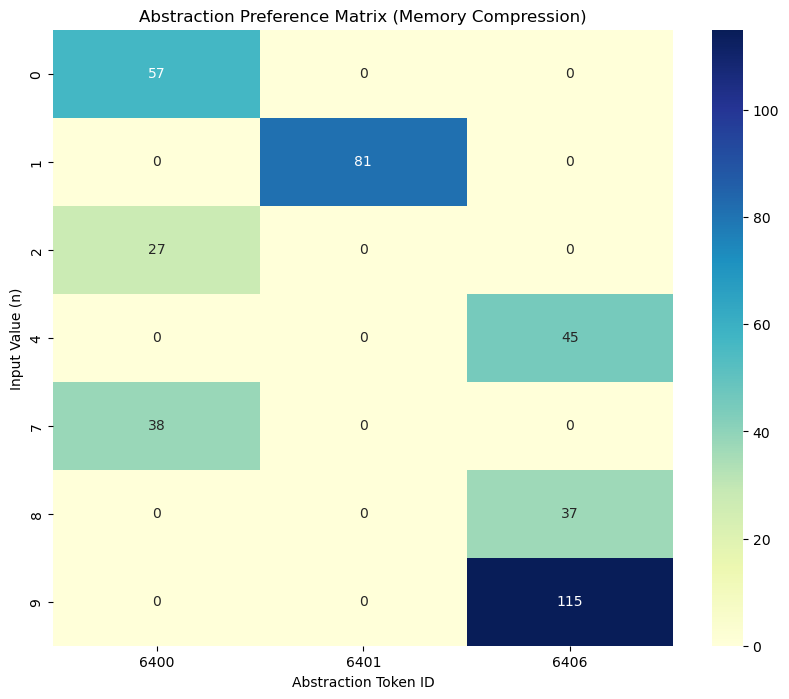

In [4]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("model/")
eval_loader = MemLoader('dataset/hidden_info.bin', device=args.device)

from src.stat import collect_abstraction_table, plot_abstraction_preference, evaluate_advantage

greedy_adv, best_adv, greedy_info_gain, greedy_loss, abstract_free_loss = evaluate_advantage(model, eval_loader, sorl_config)
print(f"Greedy Advantage: {greedy_adv:.1f}% | Best Adv: {best_adv:.1f}% | Abstract-Conditioned Loss: {greedy_loss:.3f} | Abstract-Free Loss: {abstract_free_loss:.3f} | Info Gain: {greedy_info_gain:.1f}%")                    

abs_table, val_table = collect_abstraction_table(model, eval_loader, sorl_config, tokenizer)
plot_abstraction_preference(val_table, "Abstraction Preference Matrix (Memory Compression)")

In [5]:
import torch
import torch.nn.functional as F
from src.info_gain import compute_grpo_loss
from src.sorl import heuristic_rollout, compute_per_token_loss, compute_loss, _get_per_level_tensors, evaluate
from src.utils import infer_level

# ==============================================================================
# Setup for GRPO Interactive Training
# ==============================================================================
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
search_scheduler = SearchScheduler(sorl_config)
N_INNER_LOOPS = 3  # Number of gradient updates per rollout

# ==============================================================================
# Interactive Training Loop with GRPO and Inner Loops
# ==============================================================================
print("\n--- Starting interactive training loop with GRPO and Inner Loops ---")

# --- Outer Loop (Data Collection) ---
for i in range(sorl_config.train_iterations // N_INNER_LOOPS): # Run for 5 data collection phases
    print(f"\n--- Data Collection Phase {i+1}/{sorl_config.train_iterations // N_INNER_LOOPS} ---")
    
    # 1. Generate rollout data and log_probs with the CURRENT model state (once per phase)
    model.eval()
    model.drop_ratio = 1.0 
    
    with torch.no_grad():
        data, loss_mask = train_loader.get_batch(args.batch_size)
        
        # Rollout generates candidate sequences
        search_data, search_data_idx = heuristic_rollout(data, model, l=sorl_config.l, n=sorl_config.n, config=sorl_config)
        
        # Compute the log_probs from the policy that generated these actions
        ppt_old = compute_per_token_loss(model, search_data)
        old_log_probs_dict = _get_per_level_tensors(search_data, model, -ppt_old)
        
        # Convert dict to list for the GRPO function
        old_log_probs_list = [old_log_probs_dict.get(l) for l in range(1, len(model.vocab_sizes))]

    print(f"Collected rollout data of shape: {search_data.shape}")
    
    # --- Inner Loop (Policy Optimization) ---
    model.train() 
    for j in range(N_INNER_LOOPS):
        # 2. Forward Pass with CURRENT (evolving) Policy on the SAME data
        ppt_new = compute_per_token_loss(model, search_data)
        
        # 3. Compute Losses
        ssl_loss, _ = compute_loss(search_data, model, ppt_new, loss_mask)
        
        grpo_loss = compute_grpo_loss(
            model=model, data=search_data, sample_idx=search_data_idx,
            ppt=ppt_new, loss_mask=loss_mask, old_log_probs=old_log_probs_list, epsilon=0.2
        )
        total_loss = ssl_loss + grpo_loss
        
        # 4. Optimizer Step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        greedy_advantage, best_advantage, greedy_info_gain, _, abstract_free_loss = evaluate(data, loss_mask, sorl_config, model, search_n=1)
        print(
            f"  Inner Step {j+1}/{N_INNER_LOOPS} | "
            f"Total Loss: {total_loss.item():.4f} (SSL: {ssl_loss.item():.4f}, GRPO: {grpo_loss.item():.4f}) | Greedy-Adv: {greedy_advantage:.1f}% | Greedy-Info-Gain: {greedy_info_gain:.1f}% | Abs-Free-Loss: {abstract_free_loss:.3f}"
        )


--- Starting interactive training loop with GRPO and Inner Loops ---

--- Data Collection Phase 1/133 ---
Collected rollout data of shape: torch.Size([20, 4])
  Inner Step 1/3 | Total Loss: 0.0284 (SSL: 0.0284, GRPO: 0.0000) | Greedy-Adv: 51.5% | Greedy-Info-Gain: 93.8% | Abs-Free-Loss: 0.368
  Inner Step 2/3 | Total Loss: -0.0244 (SSL: 0.0143, GRPO: -0.0387) | Greedy-Adv: 34.2% | Greedy-Info-Gain: 94.0% | Abs-Free-Loss: 0.344
  Inner Step 3/3 | Total Loss: 0.0093 (SSL: 0.0074, GRPO: 0.0019) | Greedy-Adv: -60.2% | Greedy-Info-Gain: 95.2% | Abs-Free-Loss: 0.316

--- Data Collection Phase 2/133 ---
Collected rollout data of shape: torch.Size([20, 4])
  Inner Step 1/3 | Total Loss: 0.0747 (SSL: 0.0748, GRPO: -0.0000) | Greedy-Adv: 85.9% | Greedy-Info-Gain: 97.7% | Abs-Free-Loss: 0.479
  Inner Step 2/3 | Total Loss: 0.0517 (SSL: 0.0517, GRPO: 0.0000) | Greedy-Adv: 69.0% | Greedy-Info-Gain: 98.1% | Abs-Free-Loss: 0.495
  Inner Step 3/3 | Total Loss: 0.0374 (SSL: 0.0374, GRPO: 0.0000) | Gre

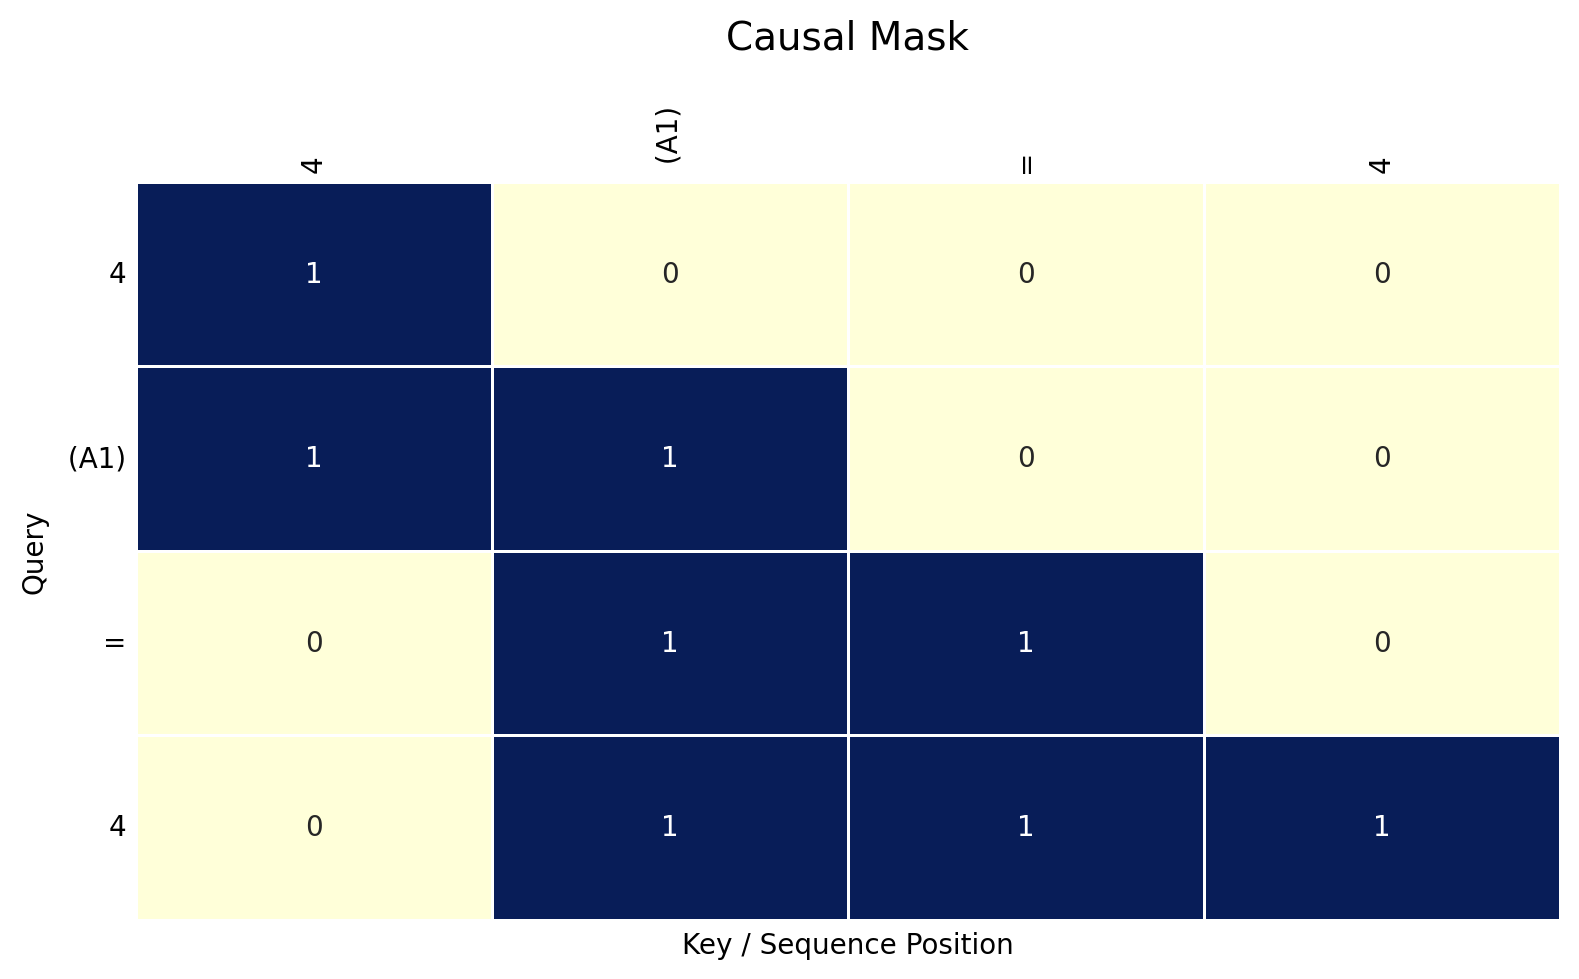

In [ ]:
from model.model_sorl import compute_attn_mask
from src.stat import AttentionMaskVisualizer
from transformers import AutoTokenizer
from src.sorl import infer_level
self = model 
input_ids = search_data
tokenizer = AutoTokenizer.from_pretrained("model/")

sorl_causal_mask = compute_attn_mask(
    input_ids, 
    self.vocab_sizes, 
    self.memory_span, 
    pad_token_id=self.pad_token_id,
    drop_ratio=self.drop_ratio
)
levels = infer_level(input_ids, self.vocab_sizes, -1)


visualizer = AttentionMaskVisualizer(input_ids, levels, sorl_causal_mask, tokenizer)
attn_map = visualizer.plot(title="Memory Compression Mask")
attn_arc = visualizer.plot_arcs(title="Attention Arcs")

Greedy Advantage: 40.5% | Best Adv: 36.9% | Abstract-Conditioned Loss: 0.000 | Abstract-Free Loss: 0.175 | Info Gain: 84.3%


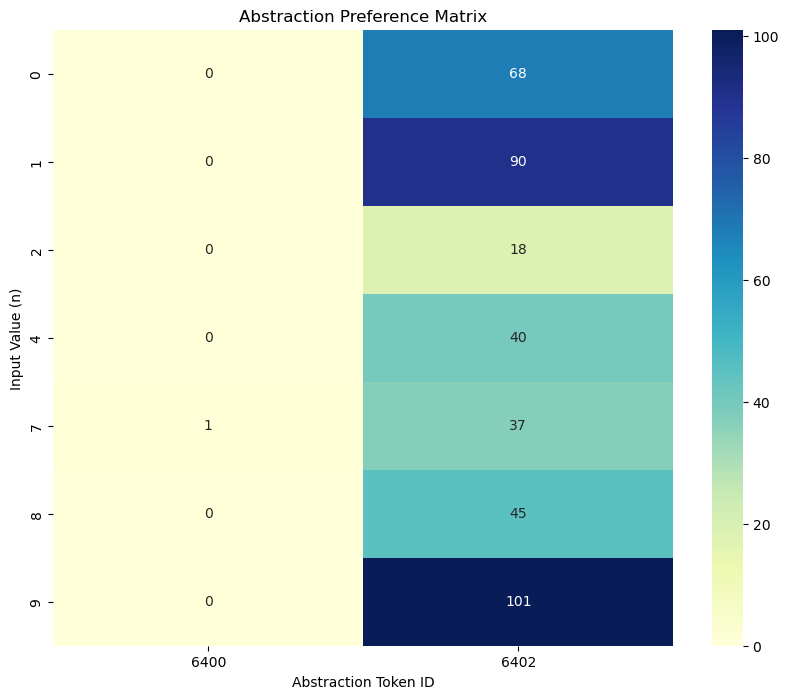

In [8]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("model/")
eval_loader = MemLoader('dataset/hidden_info.bin', device=args.device)

from src.stat import collect_abstraction_table, plot_abstraction_preference, evaluate_advantage

greedy_adv, best_adv, greedy_info_gain, greedy_loss, abstract_free_loss = evaluate_advantage(model, eval_loader, sorl_config)
print(f"Greedy Advantage: {greedy_adv:.1f}% | Best Adv: {best_adv:.1f}% | Abstract-Conditioned Loss: {greedy_loss:.3f} | Abstract-Free Loss: {abstract_free_loss:.3f} | Info Gain: {greedy_info_gain:.1f}%")                    

abs_table, val_table = collect_abstraction_table(model, eval_loader, sorl_config, tokenizer)
plot_abstraction_preference(val_table)